# **Download the Brain Tumor MRI Dataset**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [379]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, AveragePooling2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, AdamW, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2

In [3]:
path

'/kaggle/input/brain-tumor-mri-dataset'

In [4]:
os.listdir(path)

['Training', 'Testing']

In [5]:
numClasses = len(os.listdir(f"{path}/Training"))
print(f"Number of Classes are {numClasses}")

Number of Classes are 4


In [6]:
Classespaths = []

for i in os.listdir(f"{path}/Training"):
    Classespaths.append(f"{path}/Training/{i}")

In [7]:
Classes = []
totalImgs = 0
totalTestImgs = 0
for i in Classespaths:
    print(i)
    Classes.append(i.split('/')[-1])
    totalImgs += len(os.listdir(i))


/kaggle/input/brain-tumor-mri-dataset/Training/pituitary
/kaggle/input/brain-tumor-mri-dataset/Training/notumor
/kaggle/input/brain-tumor-mri-dataset/Training/meningioma
/kaggle/input/brain-tumor-mri-dataset/Training/glioma


In [8]:
for i in Classes:
  totalTestImgs += len(os.listdir(f"{path}/Testing/{i}"))
print(f"Total Number of Training Images are {totalImgs}")
print(f"Total Number of Test Images are {totalTestImgs}")
print("Ratio =>", round(totalImgs/totalTestImgs), ': 1')

Total Number of Training Images are 5712
Total Number of Test Images are 1311
Ratio => 4 : 1


## **Some Insights on the Data**

/tmp/ipython-input-3918306200.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


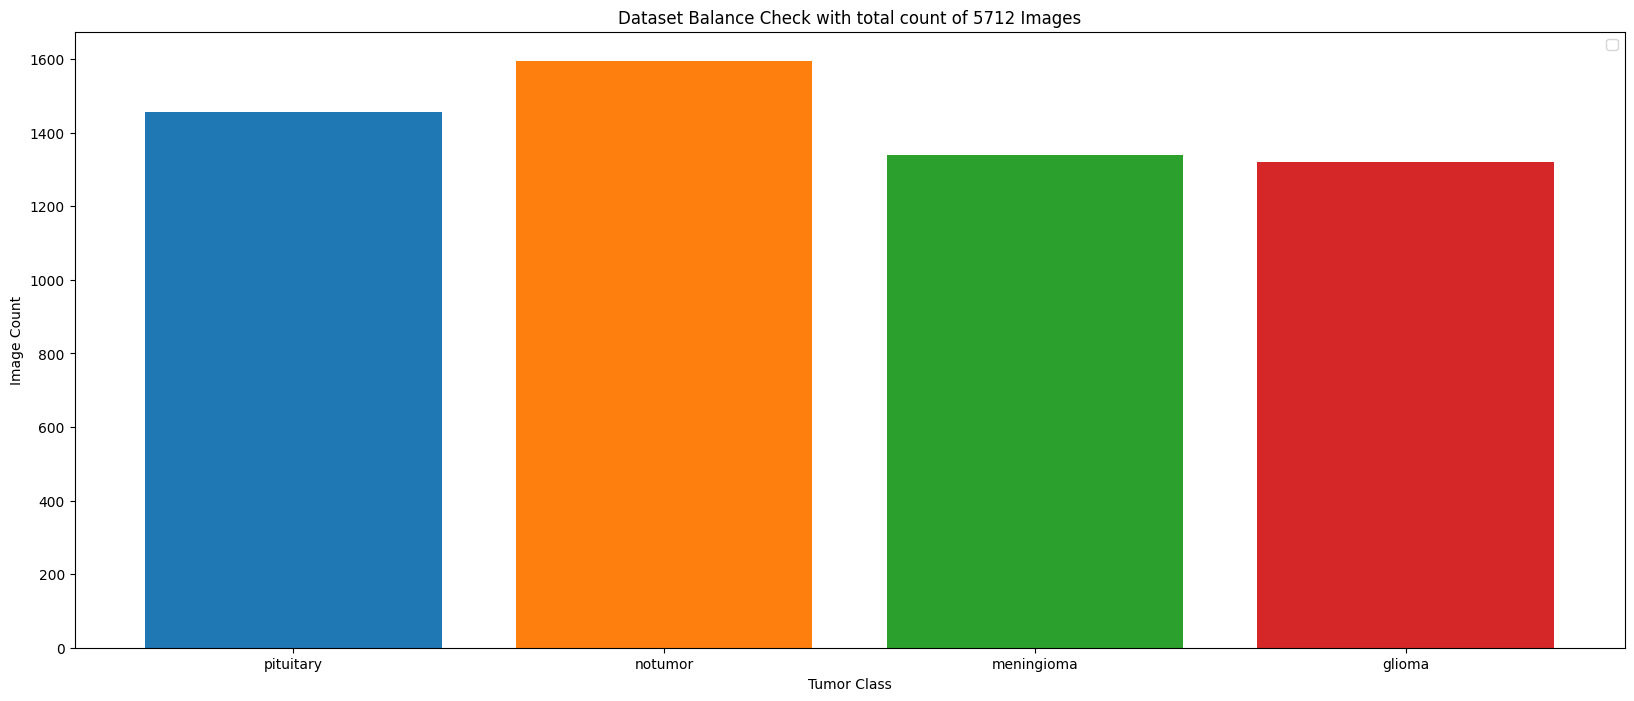

In [9]:
plt.figure(figsize=(20,8))
plt.title(f"Dataset Balance Check with total count of {totalImgs} Images")
for i, pth in enumerate(Classespaths):
  plt.bar(Classes[i],len(os.listdir(pth)))
plt.xlabel('Tumor Class')
plt.ylabel('Image Count')
plt.legend()
plt.show()


### Plotting and Visualizing a random Image

In [10]:
randomClass = random.choice(os.listdir(f"{path}/Training/"))
randomImg = os.path.join(path,'Training',randomClass, random.choice(os.listdir(f"{path}/Training/{randomClass}")))
randomImage = cv2.imread(randomImg)

#### Shape of the images is in RGB (channel of 3)

In [11]:
print(randomImage.shape)

(512, 512, 3)


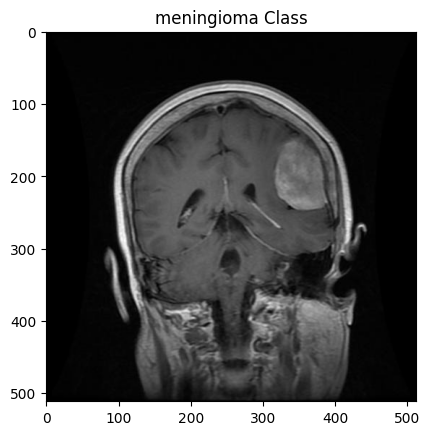

In [12]:
plt.imshow(randomImage)
plt.title(f"{randomClass} Class")
plt.show()

In [318]:
TrainGen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = 0.2,
    validation_split=0.2,
)
TestGen = ImageDataGenerator(
    rescale=1./255
)

In [319]:
TrainSet = TrainGen.flow_from_directory(
    f"{path}/Training",
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset="training"
)

Found 4571 images belonging to 4 classes.


In [320]:
TestSet = TestGen.flow_from_directory(
    f"{path}/Testing",
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
)

Found 1311 images belonging to 4 classes.


In [321]:
ValSet = TrainGen.flow_from_directory(
    f"{path}/Training",
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset = 'validation'
)

Found 1141 images belonging to 4 classes.


# **Model**

In [322]:
TumorMap = {0: 'glioma', 1: 'meningioma', 2 : 'notumor', 3: 'pituitary'}

In [361]:
model = Sequential()

model.add(Conv2D(64, (5,5), activation="relu", input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5,5), activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (4,4), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (4,4), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation="relu", kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.65))
model.add(Dense(4, activation="softmax"))


#### Callbacks & Optims

In [363]:
optimizer = AdamW(learning_rate=0.0008)
earlyStopping = EarlyStopping(patience=4, verbose=1, restore_best_weights=True, monitor='val_loss')
lrSch = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('bestModel.keras', verbose=1, save_best_only=True, monitor='val_loss')
loss = CategoricalCrossentropy()

In [364]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [365]:
model.layers

[<Conv2D name=conv2d_220, built=True>,
 <MaxPooling2D name=max_pooling2d_216, built=True>,
 <Dropout name=dropout_256, built=True>,
 <Conv2D name=conv2d_221, built=True>,
 <MaxPooling2D name=max_pooling2d_217, built=True>,
 <Dropout name=dropout_257, built=True>,
 <Conv2D name=conv2d_222, built=True>,
 <MaxPooling2D name=max_pooling2d_218, built=True>,
 <Dropout name=dropout_258, built=True>,
 <Conv2D name=conv2d_223, built=True>,
 <MaxPooling2D name=max_pooling2d_219, built=True>,
 <Dropout name=dropout_259, built=True>,
 <Flatten name=flatten_56, built=True>,
 <Dense name=dense_113, built=True>,
 <Dropout name=dropout_260, built=True>,
 <Dense name=dense_114, built=True>]

In [366]:
x_batch, y_batch = next(iter(TrainSet))
print("Batch X shape:", x_batch.shape)
print("Batch Y shape:", y_batch.shape)
print("Example Y:", y_batch[0])
print("Train classes:", TrainSet.class_indices)
print("Val classes:", ValSet.class_indices)

Batch X shape: (32, 224, 224, 1)
Batch Y shape: (32, 4)
Example Y: [0. 0. 1. 0.]
Train classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Val classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [367]:
history = model.fit(
    TrainSet,
    validation_data=ValSet,
    epochs=30,
    verbose=1,
    callbacks=[earlyStopping, lrSch, checkpoint]
)

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.3478 - loss: 1.3241
Epoch 1: val_loss improved from inf to 1.25357, saving model to bestModel.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 47s 274ms/step - accuracy: 0.3483 - loss: 1.3234 - val_accuracy: 0.4321 - val_loss: 1.2536 - learning_rate: 8.0000e-04
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5800 - loss: 0.9896
Epoch 2: val_loss improved from 1.25357 to 1.10145, saving model to bestModel.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 241ms/step - accuracy: 0.5803 - loss: 0.9892 - val_accuracy: 0.5653 - val_loss: 1.1015 - learning_rate: 8.0000e-04
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6900 - loss: 0.7821
Epoch 3: val_loss improved from 1.10145 to 0.88410, saving model to bestModel.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 263ms/step - accuracy: 0.6901 - loss: 0.7820 - val_accuracy: 0.6635 - val_loss: 0.8841 - learning_rate: 8.0000e-04
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1

# Testing!

In [375]:
testingLoss, TestingAcc = model.evaluate(TestSet)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9350 - loss: 0.2344


In [378]:
print("Testing Accuracy: ", round(TestingAcc,2))

Testing Accuracy:  0.94


In [369]:
TrainingAccuracies = history.history['accuracy']
valAccuracies = history.history['val_accuracy']
TrainingLoss = history.history['loss']
ValLoss = history.history['val_loss']

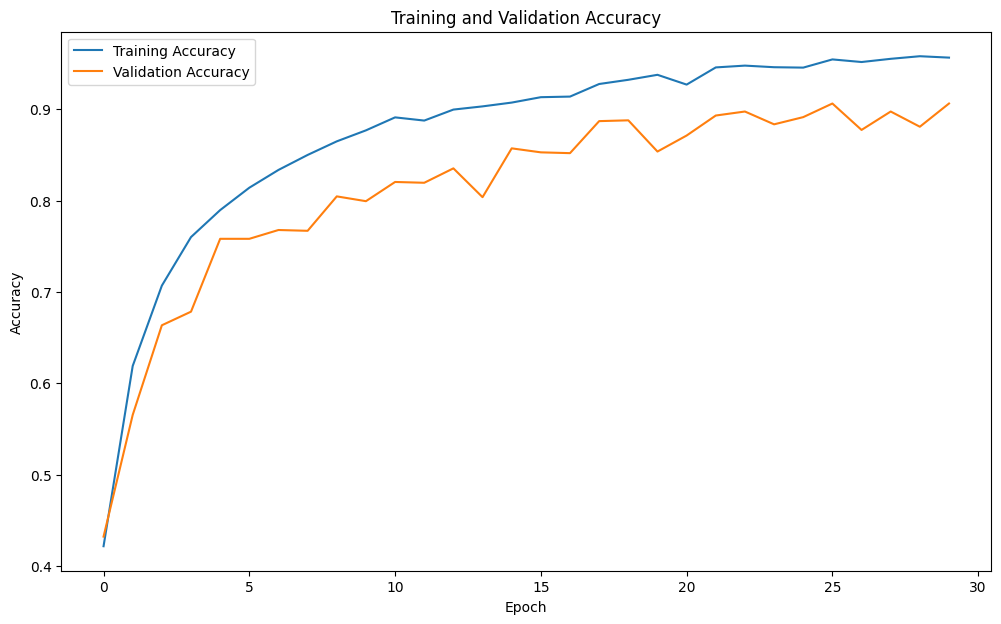

In [370]:
plt.figure(figsize=(12, 7))
plt.title('Training and Validation Accuracy')
plt.plot(TrainingAccuracies, label='Training Accuracy')
plt.plot(valAccuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

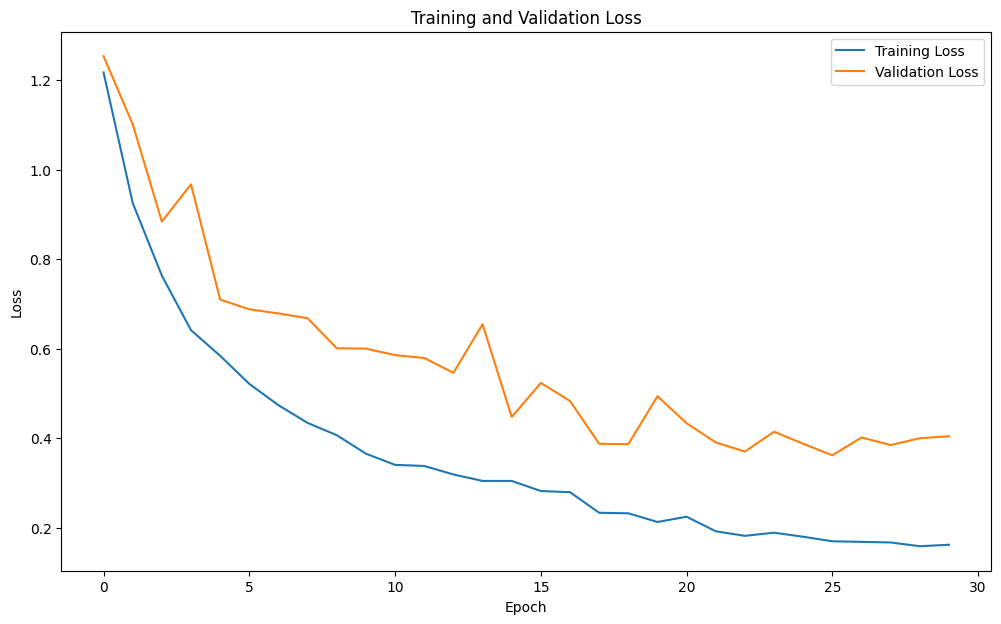

In [371]:
plt.figure(figsize=(12, 7))
plt.title('Training and Validation Loss')
plt.plot(TrainingLoss, label='Training Loss')
plt.plot(ValLoss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Some Image Plotting & Test by Visualization

In [381]:
images, labels = next(iter(TestSet))
np.random.seed(42)
random_indices = np.random.choice(len(images), size=8, replace=False)

In [382]:
testImages = images[random_indices]
testLabels = labels[random_indices]
predictedLabels = model.predict(testImages)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


## Results

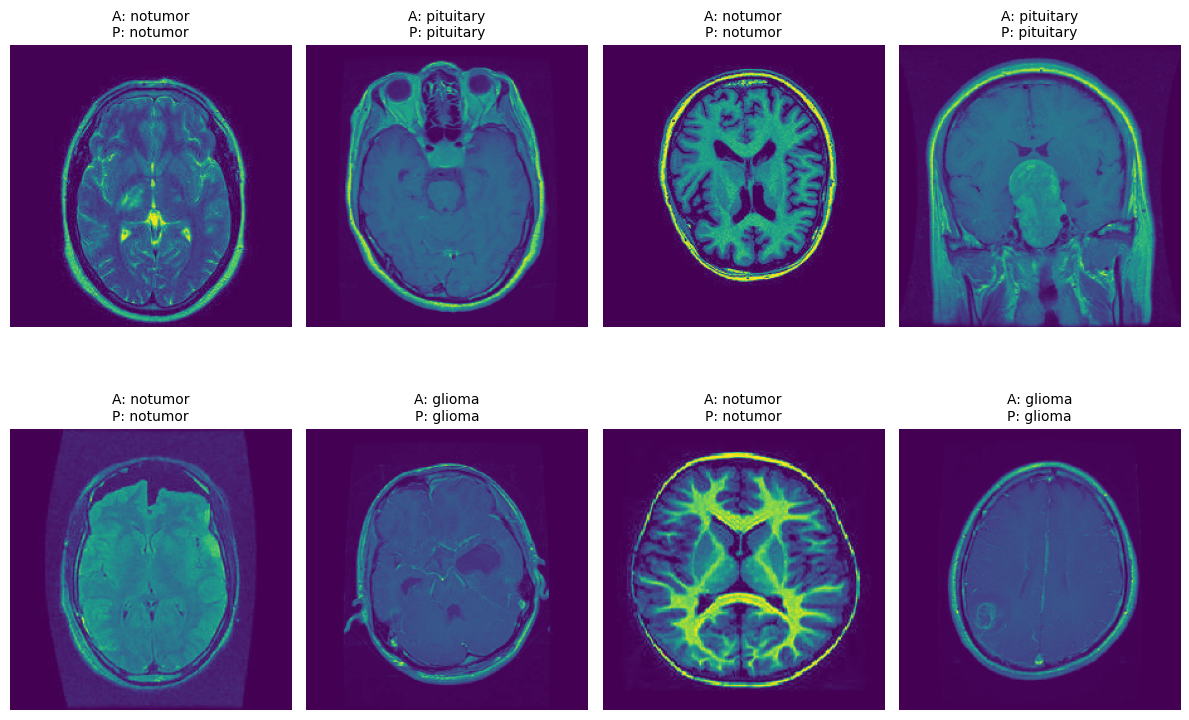

In [383]:
n = 8
rows = 3
cols = 4

plt.figure(figsize=(12, 12))

for i in range(n):
    actualLabel = TumorMap[np.argmax(testLabels[i])]
    predictedLabel = TumorMap[np.argmax(predictedLabels[i])]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(testImages[i])
    plt.title(f"A: {actualLabel}\nP: {predictedLabel}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


## **Confusion Matrix**

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


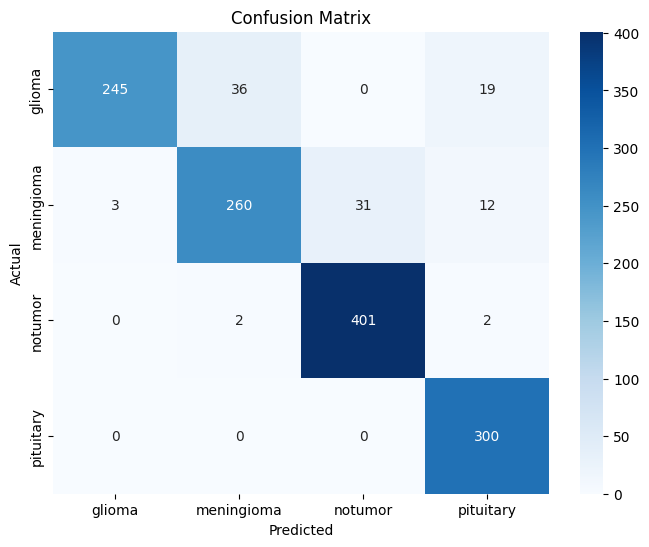

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = list(TestSet.class_indices.keys())

preds = model.predict(TestSet)
pred_labels = np.argmax(preds, axis=1)

true_labels = TestSet.classes

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# 👋